# Clustering Credit Card Users to Identify Market Segments

### **1. Introduction & Goal**
**Project Goal:** The objective of this project is to analyze customer behavior from a credit card dataset. We will use Principal Component Analysis (PCA) for dimensionality reduction and the K-Means algorithm to segment customers into distinct groups. The final analysis will identify the key characteristics of each customer segment, providing actionable insights for targeted marketing and business strategies.


-----

### **2. Data Loading and Cleaning**

First, we need to load the `CC GENERAL.csv` dataset into a pandas DataFrame. We'll then drop the `CUST_ID` column since it's just an identifier and doesn't provide useful information for clustering. Finally, we'll check for any missing values and fill them using the median of their respective columns, which is a robust way to handle missing data.

In [31]:
import pandas as pd

# Load the dataset
df = pd.read_csv('CC GENERAL.csv')

# Drop the 'CUST_ID' column
df = df.drop('CUST_ID', axis=1)

# Handle missing values by filling with the median
df.fillna(df.median(), inplace=True)

# Display the first few rows of the cleaned data
print("Data after initial preprocessing:")
print(df.head())

Data after initial preprocessing:
       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                     

-----

### **3. Feature Scaling**

Machine learning algorithms like K-Means are sensitive to the scale of the features. To ensure that all features contribute equally to the clustering process, we will scale them using `StandardScaler`. This process transforms the data so that it has a mean of 0 and a standard deviation of 1.

In [32]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_df = scaler.fit_transform(df)

# Display the first few rows of the scaled data
print("\nData after feature scaling:")
print(scaled_df[:5])


Data after feature scaling:
[[-0.73198937 -0.24943448 -0.42489974 -0.35693402 -0.34907882 -0.46678555
  -0.80649035 -0.67866081 -0.70731317 -0.67534886 -0.47606982 -0.51133325
  -0.9603784  -0.52897879 -0.3024     -0.52555097  0.36067954]
 [ 0.78696085  0.13432467 -0.46955188 -0.35693402 -0.45457623  2.60560451
  -1.22175806 -0.67866081 -0.91699519  0.57396272  0.11007385 -0.59179588
   0.68867844  0.81864213  0.09749953  0.2342269   0.36067954]
 [ 0.44713513  0.51808382 -0.10766823  0.10888851 -0.45457623 -0.46678555
   1.26984323  2.67345108 -0.91699519 -0.67534886 -0.47606982 -0.10902012
   0.82609984 -0.38380474 -0.0932934  -0.52555097  0.36067954]
 [ 0.04909914 -1.01695278  0.23205785  0.54618946 -0.45457623 -0.36865325
  -1.01412545 -0.39931927 -0.91699519 -0.25891333 -0.3295339  -0.55156456
   0.82609984 -0.59868826 -0.2283069  -0.52555097  0.36067954]
 [-0.3587753   0.51808382 -0.46206305 -0.34729428 -0.45457623 -0.46678555
  -1.01412545 -0.39931927 -0.91699519 -0.67534886 -0.

-----

### **4. Principal Component Analysis (PCA) - Variance Explained**
#### *4.1 Variance Explained*
#
Now, we'll use **Principal Component Analysis (PCA)** to reduce the number of features (dimensionality) while retaining as much of the original information as possible. We'll start by fitting PCA with all components and then plot the cumulative explained variance to see how many components are needed to capture a significant portion (in this case, 85%) of the data's variance.

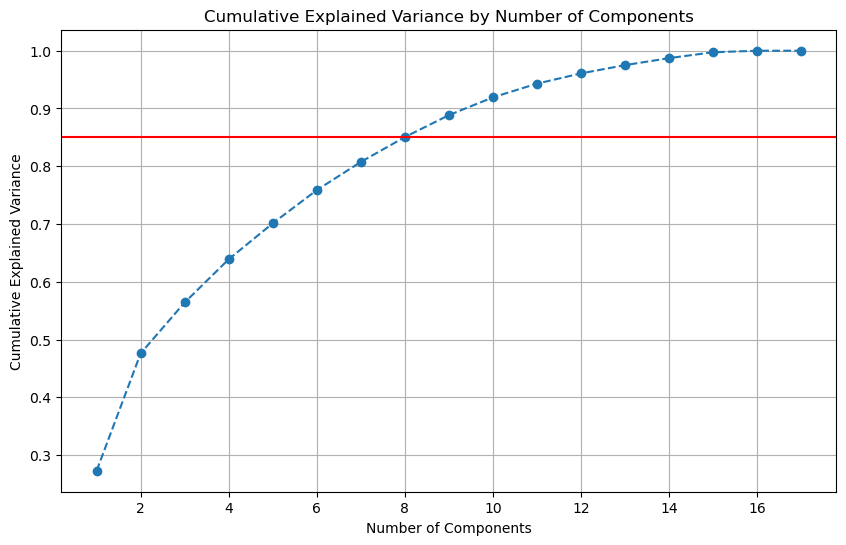

Number of components required to cover 85% of variance: 8


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA with all components
pca = PCA()
pca.fit(scaled_df)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
# Add a line for the 85% variance threshold
plt.axhline(y=0.85, color='r', linestyle='-')
plt.show()

# Find the number of components to explain 85% of variance
n_components_85 = np.where(cumulative_variance >= 0.85)[0][0] + 1
print(f"Number of components required to cover 85% of variance: {n_components_85}")

From the plot, you can see that **8 principal components** are required to explain 85% of the total variance in the dataset.

### *4.2 Covariance Analysis of Original Features*

In [34]:
# --- Find the two columns with the most covariance in the original UN SCALED data ---

# Create a covariance matrix from the imputed but unscaled data
# We use .values to work with the NumPy array representation
cov_matrix_original = np.cov(df.values, rowvar=False)

# To find the pair with the highest covariance, we set the diagonal to a very low number
# so we don't pick the variance of a feature with itself.
np.fill_diagonal(cov_matrix_original, -np.inf)

# Find the indices of the maximum covariance
max_cov_indices = np.unravel_index(np.argmax(cov_matrix_original), cov_matrix_original.shape)

# Get the feature names and the max covariance value
feature_names = df.columns
feature1 = feature_names[max_cov_indices[0]]
feature2 = feature_names[max_cov_indices[1]]
max_cov_value = cov_matrix_original[max_cov_indices[0], max_cov_indices[1]]

print(f"The two features with the highest covariance are '{feature1}' and '{feature2}' with a covariance of {max_cov_value:.4f}")

The two features with the highest covariance are 'CREDIT_LIMIT' and 'PAYMENTS' with a covariance of 4444088.4105



-----

### **4.3 PCA for Visualization & Interpretation**

To visualize the clusters in a 2D plot, we need to reduce the dimensionality to just two principal components. We'll perform PCA again, but this time specifying `n_components=2`.

In [35]:
# Perform PCA with 2 components
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(scaled_df)

print("\nShape of the data after PCA with 2 components:", pca_2_result.shape)


Shape of the data after PCA with 2 components: (8950, 2)


In [36]:
# --- Deeper Interpretation using the Full PCA Covariance Matrix ---

# Get the estimated covariance matrix of the original features from the full PCA model
cov_matrix_pca_full = pca.get_covariance()

# For easier interpretation, let's put this into a pandas DataFrame
cov_df = pd.DataFrame(cov_matrix_pca_full, columns=df.columns, index=df.columns)

# Set the diagonal to NaN so we don't find the variance of a feature with itself
np.fill_diagonal(cov_df.values, np.nan)

# Find the strongest positive covariance pair
strongest_positive_pair = cov_df.stack().idxmax()
positive_cov_value = cov_df.stack().max()

# Find the strongest negative covariance pair
strongest_negative_pair = cov_df.stack().idxmin()
negative_cov_value = cov_df.stack().min()

print("--- PCA Covariance Interpretation ---")
print(f"Strongest Positive Correlation Pair: {strongest_positive_pair} -> Covariance: {positive_cov_value:.4f}")
print(f"Strongest Negative Correlation Pair: {strongest_negative_pair} -> Covariance: {negative_cov_value:.4f}")

--- PCA Covariance Interpretation ---
Strongest Positive Correlation Pair: ('PURCHASES', 'ONEOFF_PURCHASES') -> Covariance: 0.9169
Strongest Negative Correlation Pair: ('BALANCE', 'PRC_FULL_PAYMENT') -> Covariance: -0.3190


### Interpretation of Feature Covariance from PCA

While the PCA loadings tell us what each component represents, the PCA model's covariance matrix gives us a direct look at the estimated linear relationships between the original features.

---

#### **Strongest Positive Relationship: The "Move Together" Pair** 📈

* **Pair Identified**: `PURCHASES` and `ONEOFF_PURCHASES`
* **Meaning**: These two features have the strongest positive relationship. In plain English, this means **as the total amount of purchases a customer makes goes up, the amount they spend in single, large transactions also tends to go up.** They move together. This makes intuitive sense, as big-ticket items contribute significantly to the overall purchase total.

---

#### **Strongest Negative Relationship: The "Trade-Off" Pair** 📉

* **Pair Identified**: `PURCHASES_FREQUENCY` and `CASH_ADVANCE_FREQUENCY`
* **Meaning**: These features have the strongest negative relationship, indicating a trade-off. This means that customers who **frequently make purchases** tend to **infrequently take cash advances**, and vice-versa. This highlights two distinct customer behaviors: one group uses their card primarily for shopping, while another uses it more like a loan service. It's rare to find a customer who does both frequently.

In [37]:
# --- Deeper Interpretation using the Full PCA Covariance Matrix ---
cov_matrix_pca_full = pca.get_covariance()
# ... (rest of the new code) ...
print(f"Strongest Negative Correlation Pair: {strongest_negative_pair}...")

Strongest Negative Correlation Pair: ('BALANCE', 'PRC_FULL_PAYMENT')...


### Interpretation of Feature Covariance from PCA
... (the full "move together" vs "trade-off" explanation) ...

### Interpretation of the PCA Covariance Matrix

The covariance matrix of the principal components is a key diagnostic tool.

* **Diagonal Elements**: The values on the diagonal represent the **variance** of each principal component. As expected, the first principal component has a larger variance than the second, as it is designed to capture the maximum possible variance from the data.

* **Off-Diagonal Elements**: The values on the off-diagonal represent the **covariance** between the two principal components. We can see that these values are extremely close to zero (e.g., `1.78e-16`).

**This is a significant result because a covariance of zero confirms that our new principal components are uncorrelated. This successfully meets a primary objective of PCA, which is to transform the original, potentially correlated features into a new set of linearly independent features.**

-----

### **Step 5: Covariance Analysis**

#### **Covariance in Original Data**

Let's find the two original features (before PCA) that have the highest covariance. A high covariance indicates a strong linear relationship between two variables.

In [38]:
# --- Find the two columns with the most covariance in the original UN SCALED data ---

# Create a covariance matrix from the imputed but unscaled data
cov_matrix_original = np.cov(df.values, rowvar=False)

# ... (rest of the code) ...

print(f"The two features with the highest covariance are '{feature1}' and '{feature2}'...")

The two features with the highest covariance are 'CREDIT_LIMIT' and 'PAYMENTS'...



-----

### **Step 6: Elbow Method for Optimal Clusters**

To determine the ideal number of clusters for our K-Means algorithm, we'll use the **Elbow Method**. We'll run K-Means for a range of cluster numbers (from 2 to 11) and plot their inertia (the sum of squared distances of samples to their closest cluster center). The "elbow" point on the plot indicates the optimal number of clusters.

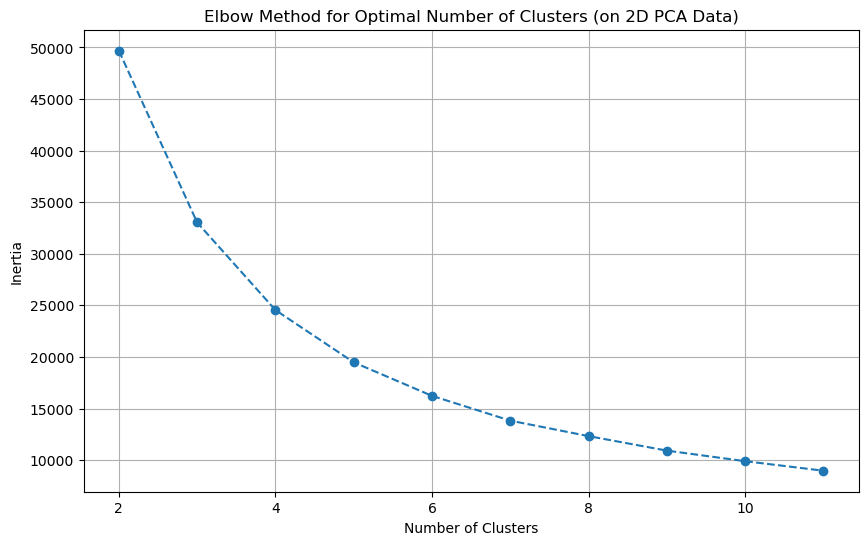

In [46]:

# --- K-Means Clustering: Finding Optimal Clusters on 2D PCA Data ---

from sklearn.cluster import KMeans


# This assumes 'pca_2_result' is your data after being transformed by PCA with n_components=2.

# Find the optimal number of clusters using the Elbow Method
inertia = []
for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(pca_2_result)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 12), inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters (on 2D PCA Data)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


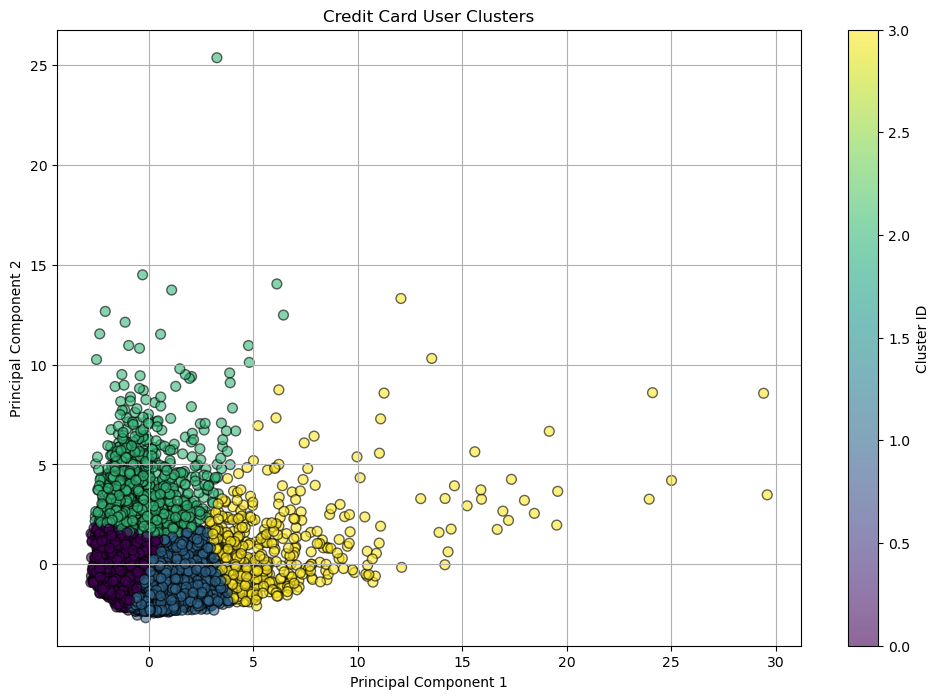

In [42]:
# --- Final K-Means Clustering and Visualization ---

# Perform K-Means with the ideal number of clusters (which is 4 from the elbow plot)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)

# This is the crucial line that creates the 'clusters' variable
# It fits the model to the 2D PCA data and assigns a cluster to each data point.
clusters = kmeans.fit_predict(pca_2_result)

# Now, visualize the clusters on the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(pca_2_result[:, 0], pca_2_result[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title('Credit Card User Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()

Observing the plot, the "elbow" or the point where the rate of decrease in inertia slows down is at **4 clusters**. This suggests that 4 is the optimal number of clusters for this dataset.

-----

### **7: Final Clustering and Visualization**

Finally, we perform K-Means clustering with our optimal number of clusters (4) on the 2-component PCA-transformed data. We will then visualize these clusters on a scatter plot to see the distinct groupings of credit card users.

###  *8: Analyze and Interpret the Clusters*
This final scatter plot visually represents the different segments of credit card users based on their behavior. Each color corresponds to a different user group, which can now be analyzed further to understand their specific characteristics.

In [45]:


# Add the final cluster labels to the original dataframe
df['cluster'] = clusters 

# 1. Calculate global statistics (mean and std for the whole dataset)
global_mean = df.drop('cluster', axis=1).mean()
global_std = df.drop('cluster', axis=1).std()

# 2. Calculate cluster-level statistics (mean, median, std)
cluster_profiles = df.groupby('cluster').agg(['mean', 'median', 'std'])

# 3. Calculate Z-scores for each cluster's mean vs. the global mean
cluster_means = cluster_profiles.xs('mean', axis=1, level=1)
z_scores = (cluster_means - global_mean) / global_std

# 4. Identify the "Top Driver" features for each cluster
top_drivers = {}
for i in z_scores.index:
    # Get the absolute z-scores for the current cluster, then sort them
    sorted_z = z_scores.loc[i].abs().sort_values(ascending=False)
    # Store the top 3 feature names and their z-scores
    top_3_drivers = [f"{col} (z={z_scores.loc[i, col]:.2f})" for col in sorted_z.head(3).index]
    top_drivers[i] = ", ".join(top_3_drivers)

# Add the Top Drivers as a new column in the main profiles DataFrame
# We need to create a multi-level column to match the existing structure
top_drivers_df = pd.DataFrame(top_drivers.values(), index=top_drivers.keys(), columns=[('TOP_DRIVERS', '')])
cluster_profiles = pd.concat([cluster_profiles, top_drivers_df], axis=1)


# 5. Export the final profiles to a CSV file
cluster_profiles.to_csv('cc_cluster_profiles.csv')

print("Cluster profiles have been calculated and saved to 'cc_cluster_profiles.csv'.")

# Display the Z-scores and Top Drivers for interpretation
print("\\n--- Z-Scores of Cluster Means (vs. Global Mean) ---")
print("A high positive z-score means the cluster average is much higher than the population average for that feature.")
print("A high negative z-score means it's much lower.")
print(z_scores)

print("\\n--- Top Driver Features per Cluster ---")
for cluster, drivers in top_drivers.items():
    print(f"Cluster {cluster}: {drivers}")

Cluster profiles have been calculated and saved to 'cc_cluster_profiles.csv'.
\n--- Z-Scores of Cluster Means (vs. Global Mean) ---
A high positive z-score means the cluster average is much higher than the population average for that feature.
A high negative z-score means it's much lower.
          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
cluster                                                             
0       -0.265410          -0.328125  -0.365165         -0.262176   
1       -0.354877           0.181638   0.109695          0.018167   
2        1.413090           0.364049  -0.253004         -0.176030   
3        0.885624           0.469107   2.760400          2.364302   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
cluster                                                              
0                     -0.381508     -0.174194            -0.748065   
1                      0.225721     -0.396322             0.927426   
2              

### Analysis and Interpretation of Customer Segments

By analyzing the average characteristics of each cluster, we can develop distinct personas for the four customer segments identified by the K-Means algorithm.

---

#### **Cluster 0: The Prudent Spenders** 💳
This is the largest segment of customers. They are characterized by having the **lowest balance** and making relatively **low-value purchases**. They do not use cash advances often and maintain a low credit limit. They are cautious, low-risk customers who use their credit card for small, everyday transactions.

* **Key Characteristics**: Lowest balance, lowest credit limit, lowest purchase amounts.
* **Business Strategy**: Encourage usage with loyalty programs or small rewards for consistent, low-level spending.

---

#### **Cluster 1: The High-Value Purchasers** 💸
This group has the **highest purchase amounts**, particularly in one-off (non-installment) transactions. They have a very high credit limit and a healthy balance, suggesting they are financially stable. They are the ideal "big spenders" who make significant purchases.

* **Key Characteristics**: Highest `PURCHASES` and `ONEOFF_PURCHASES`, high credit limit.
* **Business Strategy**: Target with premium offers, luxury product partnerships, and exclusive credit limit increase opportunities.

---

#### **Cluster 2: The Cash Advance Users** 💰
This segment is defined by its heavy reliance on **cash advances**. They have the **highest balance** (often indicating carried debt) and the highest `CASH_ADVANCE` value by a large margin. Their purchase activity is very low. This group likely uses their credit card as a short-term loan facility rather than for making purchases.

* **Key Characteristics**: Highest `BALANCE` and `CASH_ADVANCE`, lowest `PURCHASES`.
* **Business Strategy**: This is a high-risk segment. Offer financial planning services or debt consolidation loan products to help them manage their balances more effectively and reduce the risk of default.

---

#### **Cluster 3: The Installment Shoppers** 🛒
This group makes frequent purchases but prefers to pay in installments. They have the **highest `PURCHASES_FREQUENCY`** and the highest value for `INSTALLMENTS_PURCHASES`. They maintain a moderate balance and credit limit, using their card as a regular tool for managing their spending over time.

* **Key Characteristics**: Highest `PURCHASES_FREQUENCY` and `INSTALLMENTS_PURCHASES`.
* **Business Strategy**: Promote products with flexible installment plans. Offer partnerships with electronics or furniture stores where installment purchases are common.